In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import os
import pymannkendall as mk
import matplotlib.pyplot as plt
import seaborn as sns

home = "/Volumes/GoogleDrive/My Drive/Chapter2_mechanisms_forest_water_cycling"

In [2]:
# subset to anomalies
# Group by NHDPlusID, Var, and Season
# sort by year
# calculate sens slope and mann kendall trend test 

def clim_trend(Value, Year):
    sorted_values = [x for _, x in sorted(zip(Year, Value))]
    mks = mk.original_test(sorted_values)
    pvalue = mks[2]
    slope = mks[7]
    pd_list = [{'slope':slope, 'pvalue':pvalue}]
    return pd.DataFrame(pd_list)

def summarize_climate_trend(VAR):
    df = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", VAR))
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df[df['Type'] == 'anomalies']
    df_trends = df.groupby(['NHDPlusID', 'Season']).apply(lambda x: clim_trend(x.Value, x.Year))
    df_trends = df_trends.reset_index()
    df_trends.to_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + VAR))
    return 

prcp_trends = summarize_climate_trend("prcp.csv")
tmax_trends = summarize_climate_trend("tmax.csv")
tmin_trends = summarize_climate_trend("tmin.csv")
vp_trends = summarize_climate_trend("vp.csv")

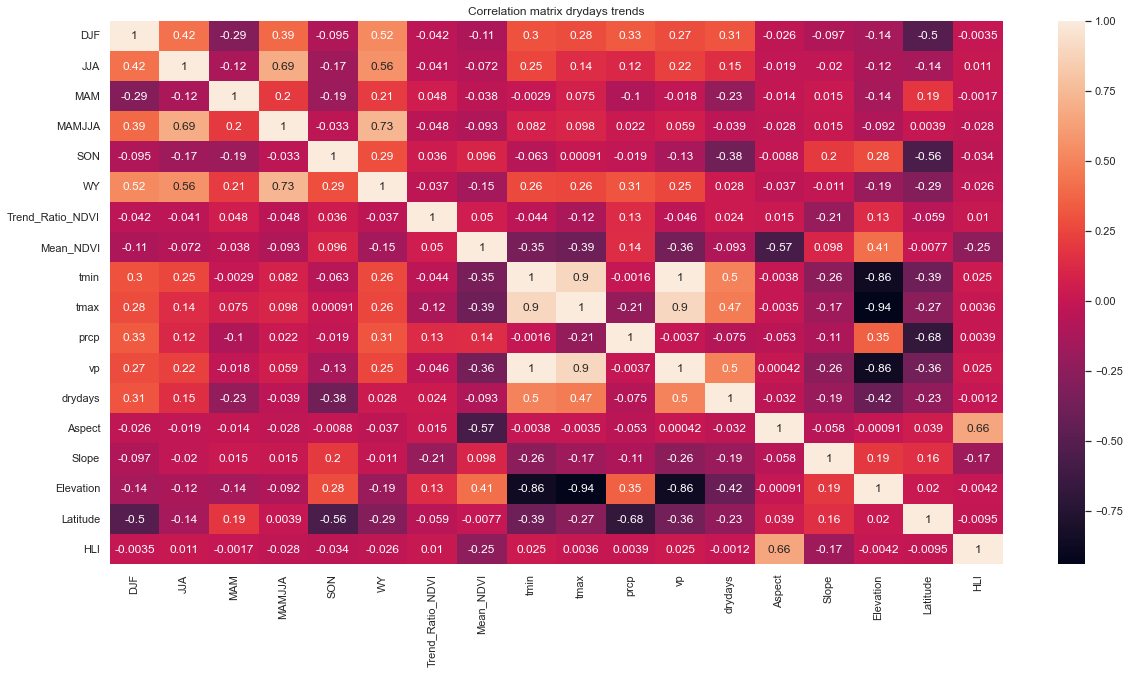

In [291]:
def get_clim_correlations(var):
    # this function only looks at significant NDVI trends and significant climate trends 
    var_summary = pd.read_csv(os.path.join(home, "Data", "catchment_avg_vars.csv"))
    var_summary = var_summary.rename({'Trend':'Trend_Ratio_NDVI'}, axis=1)
    var_summary['Trend_Ratio_NDVI'] = np.where(var_summary.Pvalue > 0.05, np.nan, var_summary.Trend_Ratio_NDVI)
    var_summary = var_summary.drop(['Pvalue', 'pct_evergreen', 'AreaSqKm_x'], axis=1)

    clim_trends = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + var + ".csv"))
    clim_trends = clim_trends.drop(clim_trends.columns[[0,3]], axis=1)
    clim_trends = clim_trends[clim_trends['pvalue'] <= 0.05]
    clim_trends_wide = clim_trends.pivot(index='NHDPlusID', columns='Season', values='slope')
    clim_trends_wide = clim_trends_wide.reset_index()

    full_df = clim_trends_wide.merge(var_summary, on='NHDPlusID', how='left')           

    hm = sns.heatmap(full_df.drop(['NHDPlusID'], axis=1).corr(), annot = True)
    hm.set(title = "Correlation matrix " + var + ' trends')
    sns.set(rc={'figure.figsize':(20,10)})
    plt.show()

get_clim_correlations('tmax')
get_clim_correlations('tmin')
get_clim_correlations('vp')
get_clim_correlations('prcp')
get_clim_correlations('drydays')

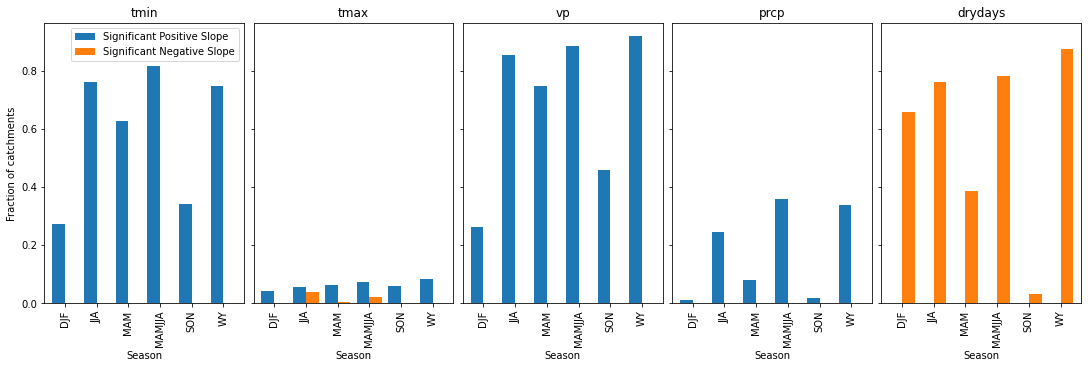

In [2]:
# summarize the climate trend extent and make a nice table and plot
def summarize_trends(slope, pval):
    pval = pval.tolist()
    slope = slope.tolist()
    keep = [i for i in range(len(pval)) if pval[i] <= 0.05]
    keep_slopes = pd.DataFrame({'SigSlope':[slope[x] for x in keep]})
    pos_slopes = keep_slopes[keep_slopes['SigSlope'] > 0].shape[0]/len(slope)
    neg_slopes = keep_slopes[keep_slopes['SigSlope'] <= 0].shape[0]/len(slope)
    dix = [{"pos_slope_pct":round(pos_slopes, 3), "neg_slope_pct":round(neg_slopes, 3)}]
    return pd.DataFrame(dix)

def summarize_climate_trends(VAR_LIST): 
    results = []
    for VAR in VAR_LIST:
        trend = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + VAR + ".csv"))
        summary = trend.groupby(['Season']).apply(lambda x: summarize_trends(x.slope, x.pvalue)).reset_index()
        summary['var'] = [VAR]*summary.shape[0]
        summary = summary.drop(['level_1'], axis=1)
        results.append(summary)

    result = pd.concat(results)
    return result   

vars = ['tmin', 'tmax', 'vp', 'prcp', 'drydays']
trends = summarize_climate_trends(vars)

# plot the brekdown of isgnficant trends by season 
fig, axes = plt.subplots(nrows=1,ncols=5, figsize=(15,5), constrained_layout=True, sharex=True, sharey=True)
trends = trends.rename(columns={"Season":"Season", "pos_slope_pct":"Significant Positive Slope", "neg_slope_pct":"Significant Negative Slope", "var":"var"})
for i, ax in zip(range(len(vars)), axes.flatten()):
    sub = trends[trends['var'] == vars[i]]
    if i == 0:
        sub.plot(x='Season', kind='bar', stacked=False, title=vars[i], ax=ax, width=0.8, legend=True, ylabel="Fraction of catchments")
    else:
        sub.plot(x='Season', kind='bar', stacked=False, title=vars[i], ax=ax, width=0.8, legend=False)


In [19]:
# make a table of the summmary statistics for climate trend and the fraction of catchments with a significant trend 
def summary_stats(var):
    trend_dt = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + var + ".csv"))
    trend_dt = trend_dt[trend_dt["Season"] == "WY"]
    trend_dt = trend_dt[trend_dt["pvalue"] <= 0.05]
    slope = trend_dt.slope
    fq = np.quantile(slope, 0.25)
    med = np.quantile(slope, 0.5)
    men = np.mean(slope)
    tq = np.quantile(slope, 0.75)
    sd = np.std(slope)
    frac = len(slope)/30044
    row = {'Pred':var,'FracSig':frac, "FQ":fq, "Median":med, "Mean":men, "TQ":tq, "SD":sd}
    return row

vars = ['tmin', 'tmax', 'vp', 'prcp']
rows = []
for var in vars:
    rows.append(summary_stats(var))

trend_summary = pd.DataFrame(rows)
trend_summary.to_csv(os.path.join(home, "climate_trend_summary_stats.csv"))


In [16]:
trend_dt = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + "tmin" + ".csv"))
trend_dt = trend_dt[trend_dt["Season"] == "WY"]
trend_dt = trend_dt[trend_dt["pvalue"] <= 0.05]
trend_dt

,Unnamed: 0,NHDPlusID,Season,level_2,slope,pvalue
5,5,1.500010e+13,WY,0,0.060502,0.000074
11,11,1.500010e+13,WY,0,0.055083,0.000434
17,17,1.500010e+13,WY,0,0.057544,0.000048
23,23,1.500010e+13,WY,0,0.061059,0.000027
29,29,1.500010e+13,WY,0,0.054795,0.000322
...,...,...,...,...,...,...
180191,180191,2.500040e+13,WY,0,0.044460,0.011595
180197,180197,2.500040e+13,WY,0,0.045809,0.012487
180239,180239,2.500040e+13,WY,0,0.030312,0.042639
180245,180245,2.500040e+13,WY,0,0.029994,0.048278


In [13]:

var = 'tmin'
season = 'JJA'

clim_trends = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + var + ".csv"))
clim_trends = clim_trends.drop(clim_trends.columns[[0,3]], axis=1)
clim_trends = clim_trends[clim_trends['pvalue'] <= 0.05]
clim_trends = clim_trends.drop(['pvalue'], axis=1)
clim_trends = clim_trends[clim_trends['Season'] == season]
clim_catch = catchments.merge(clim_trends, how = 'inner', on='NHDPlusID')
clim_catch = clim_catch.drop(['AreaSqKm_x', 'StreamLeve', 'StreamOrde', 'percent_fo'], axis=1)
clim_catch.to_file(os.path.join(home, "Data", "Climate", "climate_trend_shapefiles", var + "_", season + ".shp"))

,NHDPlusID,geometry,Season,slope
0,1.500010e+13,"POLYGON ((591227.625 4107236.558, 591229.214 4...",JJA,0.047121
1,1.500010e+13,"POLYGON ((569613.813 4110396.422, 569444.361 4...",JJA,0.058058
2,1.500010e+13,"POLYGON ((568087.452 4111947.813, 568092.216 4...",JJA,0.048955
3,1.500010e+13,"POLYGON ((574360.108 4110799.143, 574364.872 4...",JJA,0.068515
4,1.500010e+13,"POLYGON ((571111.779 4112508.784, 571101.811 4...",JJA,0.073497
...,...,...,...,...
22867,2.500030e+13,"POLYGON ((238725.719 3903120.268, 238727.288 3...",JJA,0.076610
22868,2.500030e+13,"MULTIPOLYGON (((243769.294 3890909.455, 243770...",JJA,0.077291
22869,2.500030e+13,"POLYGON ((239613.085 3903684.981, 239543.304 3...",JJA,0.075695
22870,2.500030e+13,"POLYGON ((247115.658 3903641.749, 247075.784 3...",JJA,0.075415


In [15]:
# make a shapefile for each climate variable x season 
catchments = gpd.read_file(os.path.join(home, "Data", "Catchments", "Headwater", "headwater_catchments_perm_forest_32617.shp"))
vars = ['tmin', 'tmax', 'vp', 'prcp', 'drydays']
seasons = ['SON', 'DJF', 'MAM', 'JJA', 'MAMJJA']
for i in vars:
    clim_trends = pd.read_csv(os.path.join(home, "Data", "Climate", "Summary", 'trends_' + i + ".csv"))
    clim_trends = clim_trends.drop(clim_trends.columns[[0,3]], axis=1)
    clim_trends = clim_trends[clim_trends['pvalue'] <= 0.05]
    clim_trends = clim_trends.drop(['pvalue'], axis=1)

    for j in seasons:
        season_trends = clim_trends[clim_trends['Season'] == j]
        clim_catch = catchments.merge(season_trends, how = 'inner', on='NHDPlusID')
        clim_catch = clim_catch.drop(['AreaSqKm_x', 'StreamLeve', 'StreamOrde', 'percent_fo'], axis=1)
        clim_catch.to_file(os.path.join(home, "Data", "Climate", "climate_trend_shapefiles", i + "_" + j + ".shp"))

/Users/katiemcquillan/opt/anaconda3/envs/ch2-python-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/katiemcquillan/opt/anaconda3/envs/ch2-python-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/katiemcquillan/opt/anaconda3/envs/ch2-python-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/katiemcquillan/opt/anaconda3/envs/ch2-python-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and